In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random

In [3]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [4]:
image_size = 224
batch_size = 32

save_model_filename = 'cassava.h5'

In [5]:
train = pd.read_csv('./cassava-leaf-disease-classification/train.csv')

In [6]:
train.head(10)

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3
5  1000837476.jpg      3
6  1000910826.jpg      2
7  1001320321.jpg      0
8  1001723730.jpg      4
9  1001742395.jpg      3

In [7]:
data = {"0":"Cassava Bacterial Blight (CBB)",
        "1":"Cassava Brown Streak Disease (CBSD)",
        "2":"Cassava Green Mottle (CGM)",
        "3":"Cassava Mosaic Disease (CMD)",
        "4":"Healthy"}

disease_label = pd.DataFrame(data=data.values(),index=data.keys(),columns=['Disease_Name'])

In [8]:
disease_label

Disease_Name
0       Cassava Bacterial Blight (CBB)
1  Cassava Brown Streak Disease (CBSD)
2           Cassava Green Mottle (CGM)
3         Cassava Mosaic Disease (CMD)
4                              Healthy

In [9]:
train_path = './cassava-leaf-disease-classification/train_images'

In [10]:
def image_path(image):
    return os.path.join(train_path,image)

train['image_id'] = train['image_id'].apply(image_path)

In [11]:
train.head(10)

image_id  label
0  ./cassava-leaf-disease-classification/train_im...      0
1  ./cassava-leaf-disease-classification/train_im...      3
2  ./cassava-leaf-disease-classification/train_im...      1
3  ./cassava-leaf-disease-classification/train_im...      1
4  ./cassava-leaf-disease-classification/train_im...      3
5  ./cassava-leaf-disease-classification/train_im...      3
6  ./cassava-leaf-disease-classification/train_im...      2
7  ./cassava-leaf-disease-classification/train_im...      0
8  ./cassava-leaf-disease-classification/train_im...      4
9  ./cassava-leaf-disease-classification/train_im...      3

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [13]:
train['label'] = train['label'].astype('str')

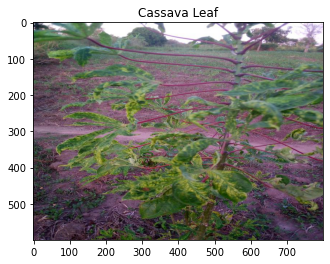

In [14]:
# display random image

index = np.random.randint(0,len(train))

plt.imshow(imread(train['image_id'][index]))
plt.title('Cassava Leaf')

plt.show()

C:\Users\pomat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


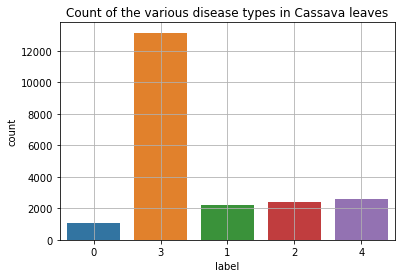

In [15]:
import seaborn as sns

sns.countplot(train['label'])
plt.title('Count of the various disease types in Cassava leaves')
plt.grid()
plt.show()

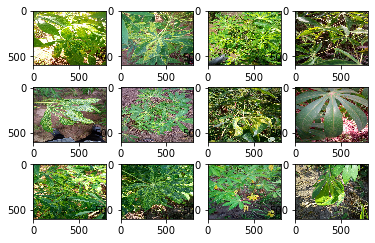

In [16]:
n_rows = 3
n_cols = 4

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        
        leaf_img = np.random.randint(0, len(train))
        img = imread(train.iloc[leaf_img]['image_id'])
        
        plt.imshow(img, cmap='binary',interpolation='nearest')

In [17]:
image_generator = ImageDataGenerator(rotation_range=15, horizontal_flip=True, vertical_flip=True,
                                     shear_range=0.2, zoom_range=0.2, brightness_range=[0.1,0.3], fill_mode='nearest', 
                                     validation_split=0.2, rescale = 1./255,
                                     preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [18]:
train_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                      subset='training', color_mode='rgb', batch_size=batch_size, seed=42,
                                                      shuffle=True, class_mode='categorical', target_size=(image_size,image_size))

Found 17118 validated image filenames belonging to 5 classes.


In [19]:
validation_generator = image_generator.flow_from_dataframe(dataframe=train, directory=None, x_col='image_id', y_col='label',
                                                   subset='validation', color_mode='rgb', batch_size=batch_size, seed=42,
                                                   shuffle=False, class_mode='categorical', target_size=(image_size,image_size))

Found 4279 validated image filenames belonging to 5 classes.


In [20]:
%reload_ext tensorboard

import datetime

In [21]:
def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1):
    x = input_layer
    
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)

    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling')(x)

    return x

In [22]:
def build_vgg(input_shape=(image_size,image_size,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=5):
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
    )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc1')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc2')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [23]:
model = build_vgg()

Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/re

Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localh

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/

In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:lo

In [25]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

In [26]:
log_dir = "logs/cassava/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint(save_model_filename, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [28]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [29]:
epoch = 50

history = model.fit(
    train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[tensorboard_callback, early_stopping, model_checkpoint, reduce_lr]
)

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteGraphSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSumm

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device 

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:loc

 64/535 [==>...........................] - ETA: 2:41 - loss: 109.7052 - accuracy: 0.6064Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


108/535 [=====>........................] - ETA: 2:27 - loss: 105.4534 - accuracy: 0.6123Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


152/535 [=======>......................] - ETA: 2:12 - loss: 100.8097 - accuracy: 0.6055Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


196/535 [=========>....................] - ETA: 1:57 - loss: 96.1364 - accuracy: 0.6083Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


240/535 [============>.................] - ETA: 1:42 - loss: 91.5896 - accuracy: 0.6109Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


284/535 [==============>...............] - ETA: 1:27 - loss: 87.1713 - accuracy: 0.6108Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


328/535 [=================>............] - ETA: 1:11 - loss: 82.9118 - accuracy: 0.6114Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


372/535 [===================>..........] - ETA: 56s - loss: 78.8561 - accuracy: 0.6127Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


460/535 [========================>.....] - ETA: 26s - loss: 71.3295 - accuracy: 0.6132Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 65.5021 - accuracy: 0.6129Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CreateSummaryFileWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Op

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

 68/535 [==>...........................] - ETA: 2:40 - loss: 22.9127 - accuracy: 0.6006Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


112/535 [=====>........................] - ETA: 2:26 - loss: 21.1913 - accuracy: 0.6044Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


156/535 [=======>......................] - ETA: 2:11 - loss: 19.6451 - accuracy: 0.6092Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


200/535 [==========>...................] - ETA: 1:56 - loss: 18.2584 - accuracy: 0.6105Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


244/535 [============>.................] - ETA: 1:41 - loss: 17.0081 - accuracy: 0.6171Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


288/535 [===============>..............] - ETA: 1:25 - loss: 15.8966 - accuracy: 0.6176Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


332/535 [=================>............] - ETA: 1:10 - loss: 14.8988 - accuracy: 0.6165Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


376/535 [====================>.........] - ETA: 55s - loss: 13.9961 - accuracy: 0.6178Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


464/535 [=========================>....] - ETA: 24s - loss: 12.4340 - accuracy: 0.6225Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 11.3736 - accuracy: 0.6231Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

120/535 [=====>........................] - ETA: 2:25 - loss: 3.3883 - accuracy: 0.6305Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


208/535 [==========>...................] - ETA: 1:55 - loss: 3.0349 - accuracy: 0.6318Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


296/535 [===============>..............] - ETA: 1:24 - loss: 2.7508 - accuracy: 0.6369Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


384/535 [====================>.........] - ETA: 53s - loss: 2.5230 - accuracy: 0.6400Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


472/535 [=========================>....] - ETA: 22s - loss: 2.3309 - accuracy: 0.6413Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 2.2111 - accuracy: 0.6459Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 4/50
Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0
 40/535 [=>............................] - ETA: 2:52 - loss: 1.3172 - accuracy: 0.6359Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


128/535 [======>.......................] - ETA: 2:24 - loss: 1.2202 - accuracy: 0.6660Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


216/535 [===========>..................] - ETA: 1:53 - loss: 1.1850 - accuracy: 0.6606Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


304/535 [================>.............] - ETA: 1:22 - loss: 1.1488 - accuracy: 0.6620Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


392/535 [====================>.........] - ETA: 50s - loss: 1.1292 - accuracy: 0.6569Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


480/535 [=========================>....] - ETA: 19s - loss: 1.1023 - accuracy: 0.6593Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.6574Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSumm

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

135/535 [======>.......................] - ETA: 2:18 - loss: 0.9490 - accuracy: 0.6650Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


223/535 [===========>..................] - ETA: 1:48 - loss: 0.9556 - accuracy: 0.6634Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


311/535 [================>.............] - ETA: 1:17 - loss: 0.9476 - accuracy: 0.6660Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


399/535 [=====================>........] - ETA: 47s - loss: 0.9415 - accuracy: 0.6673Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


487/535 [==========================>...] - ETA: 16s - loss: 0.9333 - accuracy: 0.6681Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.9326 - accuracy: 0.6688Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

 99/535 [====>.........................] - ETA: 2:34 - loss: 0.9026 - accuracy: 0.6711Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


187/535 [=========>....................] - ETA: 2:03 - loss: 0.8975 - accuracy: 0.6778Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


275/535 [==============>...............] - ETA: 1:32 - loss: 0.8978 - accuracy: 0.6776Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


363/535 [===================>..........] - ETA: 1:01 - loss: 0.8935 - accuracy: 0.6793Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


451/535 [========================>.....] - ETA: 29s - loss: 0.8947 - accuracy: 0.6776Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.8895 - accuracy: 0.6784Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in devic

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00006: val_loss did not improve from 0.89048
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==========================

122/535 [=====>........................] - ETA: 2:22 - loss: 0.9053 - accuracy: 0.6767Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


210/535 [==========>...................] - ETA: 1:52 - loss: 0.8950 - accuracy: 0.6755Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


298/535 [===============>..............] - ETA: 1:22 - loss: 0.8866 - accuracy: 0.6826Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


386/535 [====================>.........] - ETA: 51s - loss: 0.8758 - accuracy: 0.6849Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


474/535 [=========================>....] - ETA: 21s - loss: 0.8712 - accuracy: 0.6873Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.8700 - accuracy: 0.6871Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 8/50
Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0
 86/535 [===>..........................] - ETA: 2:37 - loss: 0.8688 - accuracy: 0.6847Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


174/535 [========>.....................] - ETA: 2:07 - loss: 0.8827 - accuracy: 0.6788Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


262/535 [=============>................] - ETA: 1:36 - loss: 0.8663 - accuracy: 0.6860Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


350/535 [==================>...........] - ETA: 1:05 - loss: 0.8620 - accuracy: 0.6892Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


438/535 [=======================>......] - ETA: 34s - loss: 0.8671 - accuracy: 0.6892Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


526/535 [============================>.] - ETA: 3s - loss: 0.8587 - accuracy: 0.6921Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.8580 - accuracy: 0.6920Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op W

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

 94/535 [====>.........................] - ETA: 2:36 - loss: 0.8285 - accuracy: 0.7086Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


182/535 [=========>....................] - ETA: 2:06 - loss: 0.8418 - accuracy: 0.7059Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


270/535 [==============>...............] - ETA: 1:34 - loss: 0.8557 - accuracy: 0.6956Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


358/535 [===================>..........] - ETA: 1:02 - loss: 0.8463 - accuracy: 0.6984Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


446/535 [========================>.....] - ETA: 31s - loss: 0.8364 - accuracy: 0.7012Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


534/535 [============================>.] - ETA: 0s - loss: 0.8409 - accuracy: 0.6998Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.6998Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

102/535 [====>.........................] - ETA: 2:29 - loss: 0.8171 - accuracy: 0.7017Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


190/535 [=========>....................] - ETA: 1:59 - loss: 0.8089 - accuracy: 0.7142Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


278/535 [==============>...............] - ETA: 1:29 - loss: 0.8097 - accuracy: 0.7127Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


366/535 [===================>..........] - ETA: 59s - loss: 0.8156 - accuracy: 0.7087Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


454/535 [========================>.....] - ETA: 28s - loss: 0.8193 - accuracy: 0.7082Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.8175 - accuracy: 0.7104Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00010: val_loss improved from 0.80117 to 0.78877, saving model to cassava.h5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp i

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

111/535 [=====>........................] - ETA: 2:29 - loss: 0.7884 - accuracy: 0.7264Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


199/535 [==========>...................] - ETA: 1:59 - loss: 0.8254 - accuracy: 0.7098Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


287/535 [===============>..............] - ETA: 1:28 - loss: 0.8151 - accuracy: 0.7128Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


375/535 [====================>.........] - ETA: 56s - loss: 0.8256 - accuracy: 0.7092Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


463/535 [========================>.....] - ETA: 25s - loss: 0.8193 - accuracy: 0.7109Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.7124Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

119/535 [=====>........................] - ETA: 2:23 - loss: 0.7850 - accuracy: 0.7295Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


207/535 [==========>...................] - ETA: 1:53 - loss: 0.7772 - accuracy: 0.7294Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


295/535 [===============>..............] - ETA: 1:23 - loss: 0.7797 - accuracy: 0.7283Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


383/535 [====================>.........] - ETA: 52s - loss: 0.7827 - accuracy: 0.7256Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


471/535 [=========================>....] - ETA: 22s - loss: 0.7878 - accuracy: 0.7226Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.7859 - accuracy: 0.7236Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

141/535 [======>.......................] - ETA: 2:18 - loss: 0.7869 - accuracy: 0.7254Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


229/535 [===========>..................] - ETA: 1:48 - loss: 0.7796 - accuracy: 0.7303Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


317/535 [================>.............] - ETA: 1:17 - loss: 0.7690 - accuracy: 0.7335Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


405/535 [=====================>........] - ETA: 46s - loss: 0.7620 - accuracy: 0.7361Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


493/535 [==========================>...] - ETA: 14s - loss: 0.7636 - accuracy: 0.7363Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.7607 - accuracy: 0.7368Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Execu

120/535 [=====>........................] - ETA: 2:27 - loss: 0.7628 - accuracy: 0.7385Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


208/535 [==========>...................] - ETA: 1:55 - loss: 0.7514 - accuracy: 0.7392Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


296/535 [===============>..............] - ETA: 1:23 - loss: 0.7612 - accuracy: 0.7356Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


384/535 [====================>.........] - ETA: 52s - loss: 0.7545 - accuracy: 0.7391Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


472/535 [=========================>....] - ETA: 22s - loss: 0.7541 - accuracy: 0.7404Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.7511 - accuracy: 0.7436Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 15/50
Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0
 40/535 [=>............................] - ETA: 2:46 - loss: 0.7288 - accuracy: 0.7598Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


128/535 [======>.......................] - ETA: 2:20 - loss: 0.7457 - accuracy: 0.7494Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


216/535 [===========>..................] - ETA: 1:51 - loss: 0.7575 - accuracy: 0.7482Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


304/535 [================>.............] - ETA: 1:21 - loss: 0.7451 - accuracy: 0.7530Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


392/535 [====================>.........] - ETA: 50s - loss: 0.7415 - accuracy: 0.7551Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


480/535 [=========================>....] - ETA: 19s - loss: 0.7382 - accuracy: 0.7539Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.7530Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSumm

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

135/535 [======>.......................] - ETA: 2:23 - loss: 0.7196 - accuracy: 0.7604Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


223/535 [===========>..................] - ETA: 1:51 - loss: 0.7416 - accuracy: 0.7513Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


311/535 [================>.............] - ETA: 1:19 - loss: 0.7345 - accuracy: 0.7560Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


399/535 [=====================>........] - ETA: 48s - loss: 0.7359 - accuracy: 0.7562Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


487/535 [==========================>...] - ETA: 17s - loss: 0.7381 - accuracy: 0.7548Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.7367 - accuracy: 0.7552Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

157/535 [=======>......................] - ETA: 2:10 - loss: 0.7193 - accuracy: 0.7656Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


245/535 [============>.................] - ETA: 1:40 - loss: 0.7227 - accuracy: 0.7626Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


333/535 [=================>............] - ETA: 1:10 - loss: 0.7234 - accuracy: 0.7602Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


421/535 [======================>.......] - ETA: 39s - loss: 0.7221 - accuracy: 0.7610Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


509/535 [===========================>..] - ETA: 9s - loss: 0.7237 - accuracy: 0.7607Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.7230 - accuracy: 0.7615Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================]

122/535 [=====>........................] - ETA: 2:27 - loss: 0.6833 - accuracy: 0.7743Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


210/535 [==========>...................] - ETA: 1:55 - loss: 0.6897 - accuracy: 0.7720Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


298/535 [===============>..............] - ETA: 1:24 - loss: 0.6968 - accuracy: 0.7697Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


386/535 [====================>.........] - ETA: 53s - loss: 0.6977 - accuracy: 0.7703Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


474/535 [=========================>....] - ETA: 21s - loss: 0.6956 - accuracy: 0.7723Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.7722Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 19/50
Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0
 86/535 [===>..........................] - ETA: 2:38 - loss: 0.6846 - accuracy: 0.7791Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


174/535 [========>.....................] - ETA: 2:06 - loss: 0.6838 - accuracy: 0.7807Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


262/535 [=============>................] - ETA: 1:35 - loss: 0.6845 - accuracy: 0.7802Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


350/535 [==================>...........] - ETA: 1:04 - loss: 0.6952 - accuracy: 0.7754Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


438/535 [=======================>......] - ETA: 33s - loss: 0.6970 - accuracy: 0.7748Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


526/535 [============================>.] - ETA: 3s - loss: 0.6948 - accuracy: 0.7753Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.7751Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op W

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

152/535 [=======>......................] - ETA: 2:14 - loss: 0.6822 - accuracy: 0.7801Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


240/535 [============>.................] - ETA: 1:43 - loss: 0.6899 - accuracy: 0.7769Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


328/535 [=================>............] - ETA: 1:13 - loss: 0.6810 - accuracy: 0.7792Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


416/535 [======================>.......] - ETA: 42s - loss: 0.6761 - accuracy: 0.7800Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


504/535 [===========================>..] - ETA: 10s - loss: 0.6766 - accuracy: 0.7808Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7815Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

160/535 [=======>......................] - ETA: 2:13 - loss: 0.7138 - accuracy: 0.7705Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


248/535 [============>.................] - ETA: 1:42 - loss: 0.7022 - accuracy: 0.7751Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


336/535 [=================>............] - ETA: 1:11 - loss: 0.6939 - accuracy: 0.7780Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


424/535 [======================>.......] - ETA: 39s - loss: 0.6836 - accuracy: 0.7806Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


512/535 [===========================>..] - ETA: 8s - loss: 0.6803 - accuracy: 0.7829Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6816 - accuracy: 0.7814Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

 95/535 [====>.........................] - ETA: 2:31 - loss: 0.6567 - accuracy: 0.7852Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


183/535 [=========>....................] - ETA: 2:02 - loss: 0.6470 - accuracy: 0.7913Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


271/535 [==============>...............] - ETA: 1:31 - loss: 0.6528 - accuracy: 0.7907Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


359/535 [===================>..........] - ETA: 1:01 - loss: 0.6623 - accuracy: 0.7853Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


447/535 [========================>.....] - ETA: 30s - loss: 0.6638 - accuracy: 0.7846Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7860Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/repli

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

147/535 [=======>......................] - ETA: 2:17 - loss: 0.6773 - accuracy: 0.7766Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


235/535 [============>.................] - ETA: 1:46 - loss: 0.6694 - accuracy: 0.7831Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


323/535 [=================>............] - ETA: 1:15 - loss: 0.6684 - accuracy: 0.7836Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


411/535 [======================>.......] - ETA: 44s - loss: 0.6693 - accuracy: 0.7837Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


499/535 [==========================>...] - ETA: 12s - loss: 0.6689 - accuracy: 0.7847Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7854Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 


Epoch 00023: val_loss improved from 0.64517 to 0.63629, saving model to cassava.h5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

155/535 [=======>......................] - ETA: 2:11 - loss: 0.6671 - accuracy: 0.7863Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


243/535 [============>.................] - ETA: 1:41 - loss: 0.6647 - accuracy: 0.7884Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


331/535 [=================>............] - ETA: 1:10 - loss: 0.6567 - accuracy: 0.7892Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


419/535 [======================>.......] - ETA: 40s - loss: 0.6521 - accuracy: 0.7916Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


507/535 [===========================>..] - ETA: 9s - loss: 0.6500 - accuracy: 0.7931 Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7935Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

133/535 [======>.......................] - ETA: 2:21 - loss: 0.6294 - accuracy: 0.7979Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


221/535 [===========>..................] - ETA: 1:50 - loss: 0.6237 - accuracy: 0.7984Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


309/535 [================>.............] - ETA: 1:19 - loss: 0.6219 - accuracy: 0.8024Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


397/535 [=====================>........] - ETA: 48s - loss: 0.6291 - accuracy: 0.8014Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


485/535 [==========================>...] - ETA: 17s - loss: 0.6343 - accuracy: 0.7998Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6364 - accuracy: 0.7995Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

111/535 [=====>........................] - ETA: 2:30 - loss: 0.6368 - accuracy: 0.8032Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


199/535 [==========>...................] - ETA: 1:59 - loss: 0.6295 - accuracy: 0.8062Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


287/535 [===============>..............] - ETA: 1:28 - loss: 0.6347 - accuracy: 0.8039Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


375/535 [====================>.........] - ETA: 56s - loss: 0.6406 - accuracy: 0.8003Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


463/535 [========================>.....] - ETA: 25s - loss: 0.6397 - accuracy: 0.8007Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6382 - accuracy: 0.8006Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

133/535 [======>.......................] - ETA: 2:19 - loss: 0.6538 - accuracy: 0.7991Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


221/535 [===========>..................] - ETA: 1:49 - loss: 0.6528 - accuracy: 0.7968Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


309/535 [================>.............] - ETA: 1:18 - loss: 0.6453 - accuracy: 0.7995Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


397/535 [=====================>........] - ETA: 48s - loss: 0.6383 - accuracy: 0.8009Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


485/535 [==========================>...] - ETA: 17s - loss: 0.6334 - accuracy: 0.8031Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.8009Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

111/535 [=====>........................] - ETA: 2:29 - loss: 0.6521 - accuracy: 0.7903Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


199/535 [==========>...................] - ETA: 1:59 - loss: 0.6389 - accuracy: 0.7962Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


287/535 [===============>..............] - ETA: 1:28 - loss: 0.6272 - accuracy: 0.8004Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


375/535 [====================>.........] - ETA: 56s - loss: 0.6234 - accuracy: 0.8036Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


463/535 [========================>.....] - ETA: 25s - loss: 0.6241 - accuracy: 0.8046Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.8035Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

119/535 [=====>........................] - ETA: 2:23 - loss: 0.5841 - accuracy: 0.8180Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


207/535 [==========>...................] - ETA: 1:53 - loss: 0.5988 - accuracy: 0.8140Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


295/535 [===============>..............] - ETA: 1:23 - loss: 0.5993 - accuracy: 0.8116Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


383/535 [====================>.........] - ETA: 52s - loss: 0.6057 - accuracy: 0.8094Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


471/535 [=========================>....] - ETA: 22s - loss: 0.6067 - accuracy: 0.8093Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.8078Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 30/50
Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0
 83/535 [===>..........................] - ETA: 2:37 - loss: 0.5993 - accuracy: 0.8072Executing op __inference_train_function_2846 

171/535 [========>.....................] - ETA: 2:07 - loss: 0.6088 - accuracy: 0.8080Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


259/535 [=============>................] - ETA: 1:36 - loss: 0.6091 - accuracy: 0.8087Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


347/535 [==================>...........] - ETA: 1:05 - loss: 0.6109 - accuracy: 0.8091Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


435/535 [=======================>......] - ETA: 34s - loss: 0.6085 - accuracy: 0.8110Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


523/535 [============================>.] - ETA: 4s - loss: 0.6129 - accuracy: 0.8091Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.8083Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Ex

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

 91/535 [====>.........................] - ETA: 2:33 - loss: 0.5927 - accuracy: 0.8207Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


179/535 [=========>....................] - ETA: 2:03 - loss: 0.6060 - accuracy: 0.8142Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


267/535 [=============>................] - ETA: 1:33 - loss: 0.5977 - accuracy: 0.8171Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


355/535 [==================>...........] - ETA: 1:02 - loss: 0.6128 - accuracy: 0.8107Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


443/535 [=======================>......] - ETA: 32s - loss: 0.6048 - accuracy: 0.8141Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


531/535 [============================>.] - ETA: 1s - loss: 0.6047 - accuracy: 0.8129Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6046 - accuracy: 0.8129Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

157/535 [=======>......................] - ETA: 2:11 - loss: 0.5762 - accuracy: 0.8276Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


245/535 [============>.................] - ETA: 1:40 - loss: 0.5836 - accuracy: 0.8211Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


333/535 [=================>............] - ETA: 1:10 - loss: 0.5747 - accuracy: 0.8257Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


421/535 [======================>.......] - ETA: 39s - loss: 0.5876 - accuracy: 0.8206Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


509/535 [===========================>..] - ETA: 9s - loss: 0.5975 - accuracy: 0.8159Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.8142Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

135/535 [======>.......................] - ETA: 2:21 - loss: 0.6051 - accuracy: 0.8171Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


223/535 [===========>..................] - ETA: 1:51 - loss: 0.5950 - accuracy: 0.8182Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


311/535 [================>.............] - ETA: 1:19 - loss: 0.5927 - accuracy: 0.8182Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


399/535 [=====================>........] - ETA: 48s - loss: 0.5972 - accuracy: 0.8154Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


487/535 [==========================>...] - ETA: 17s - loss: 0.5939 - accuracy: 0.8172Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.8176Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

157/535 [=======>......................] - ETA: 2:11 - loss: 0.5765 - accuracy: 0.8260Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


245/535 [============>.................] - ETA: 1:40 - loss: 0.5880 - accuracy: 0.8213Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


333/535 [=================>............] - ETA: 1:10 - loss: 0.5797 - accuracy: 0.8242Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


421/535 [======================>.......] - ETA: 39s - loss: 0.5770 - accuracy: 0.8247Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


509/535 [===========================>..] - ETA: 9s - loss: 0.5840 - accuracy: 0.8211Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.8211Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

135/535 [======>.......................] - ETA: 2:21 - loss: 0.5888 - accuracy: 0.8197Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


223/535 [===========>..................] - ETA: 1:50 - loss: 0.5913 - accuracy: 0.8204Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


311/535 [================>.............] - ETA: 1:19 - loss: 0.5886 - accuracy: 0.8221Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


399/535 [=====================>........] - ETA: 48s - loss: 0.5904 - accuracy: 0.8201Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


487/535 [==========================>...] - ETA: 17s - loss: 0.5845 - accuracy: 0.8223Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.8218Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

 99/535 [====>.........................] - ETA: 2:36 - loss: 0.5418 - accuracy: 0.8336Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


187/535 [=========>....................] - ETA: 2:05 - loss: 0.5534 - accuracy: 0.8332Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


275/535 [==============>...............] - ETA: 1:33 - loss: 0.5692 - accuracy: 0.8261Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


363/535 [===================>..........] - ETA: 1:01 - loss: 0.5669 - accuracy: 0.8285Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


451/535 [========================>.....] - ETA: 29s - loss: 0.5708 - accuracy: 0.8263Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5761 - accuracy: 0.8248Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in devic

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00036: val_loss did not improve from 0.57080
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==========================

122/535 [=====>........................] - ETA: 2:23 - loss: 0.5903 - accuracy: 0.8207Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


210/535 [==========>...................] - ETA: 1:53 - loss: 0.5787 - accuracy: 0.8237Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


298/535 [===============>..............] - ETA: 1:22 - loss: 0.5758 - accuracy: 0.8243Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


386/535 [====================>.........] - ETA: 52s - loss: 0.5801 - accuracy: 0.8221Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


474/535 [=========================>....] - ETA: 21s - loss: 0.5790 - accuracy: 0.8217Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.8221Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

144/535 [=======>......................] - ETA: 2:15 - loss: 0.5667 - accuracy: 0.8264Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


232/535 [============>.................] - ETA: 1:45 - loss: 0.5660 - accuracy: 0.8253Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


320/535 [================>.............] - ETA: 1:15 - loss: 0.5693 - accuracy: 0.8246Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


408/535 [=====================>........] - ETA: 44s - loss: 0.5664 - accuracy: 0.8267Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


496/535 [==========================>...] - ETA: 13s - loss: 0.5626 - accuracy: 0.8285Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8299Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00038: val_loss did not improve from 0.57080
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 239s 447ms/step - loss: 0.5608 - accuracy: 0.8299 - val_loss: 0.5976 - val_accuracy: 0.8175
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:

123/535 [=====>........................] - ETA: 2:22 - loss: 0.5399 - accuracy: 0.8328Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


211/535 [==========>...................] - ETA: 1:52 - loss: 0.5440 - accuracy: 0.8337Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


299/535 [===============>..............] - ETA: 1:22 - loss: 0.5521 - accuracy: 0.8327Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


387/535 [====================>.........] - ETA: 51s - loss: 0.5549 - accuracy: 0.8320Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


475/535 [=========================>....] - ETA: 20s - loss: 0.5584 - accuracy: 0.8305Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5586 - accuracy: 0.8316Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

102/535 [====>.........................] - ETA: 2:30 - loss: 0.5612 - accuracy: 0.8378Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


190/535 [=========>....................] - ETA: 1:59 - loss: 0.5515 - accuracy: 0.8421Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


278/535 [==============>...............] - ETA: 1:29 - loss: 0.5506 - accuracy: 0.8390Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


366/535 [===================>..........] - ETA: 58s - loss: 0.5586 - accuracy: 0.8344Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


454/535 [========================>.....] - ETA: 28s - loss: 0.5625 - accuracy: 0.8323Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.8329Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00040: val_loss did not improve from 0.57080
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 237s 443ms/step - loss: 0.5610 - accuracy: 0.8329 - val_loss: 0.5811 - val_accuracy: 0.8208
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/

124/535 [=====>........................] - ETA: 2:21 - loss: 0.4940 - accuracy: 0.8606Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


212/535 [==========>...................] - ETA: 1:52 - loss: 0.4881 - accuracy: 0.8583Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


300/535 [===============>..............] - ETA: 1:22 - loss: 0.4844 - accuracy: 0.8590Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


388/535 [====================>.........] - ETA: 51s - loss: 0.4856 - accuracy: 0.8581Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


476/535 [=========================>....] - ETA: 20s - loss: 0.4885 - accuracy: 0.8563Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.8575Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
E

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

 88/535 [===>..........................] - ETA: 2:38 - loss: 0.4585 - accuracy: 0.8629Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


176/535 [========>.....................] - ETA: 2:07 - loss: 0.4691 - accuracy: 0.8575Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


264/535 [=============>................] - ETA: 1:36 - loss: 0.4685 - accuracy: 0.8590Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


352/535 [==================>...........] - ETA: 1:05 - loss: 0.4679 - accuracy: 0.8586Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


440/535 [=======================>......] - ETA: 33s - loss: 0.4615 - accuracy: 0.8621Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


528/535 [============================>.] - ETA: 2s - loss: 0.4639 - accuracy: 0.8615Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.8616Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Wr

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

 96/535 [====>.........................] - ETA: 2:36 - loss: 0.4603 - accuracy: 0.8604Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


184/535 [=========>....................] - ETA: 2:05 - loss: 0.4578 - accuracy: 0.8601Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


272/535 [==============>...............] - ETA: 1:34 - loss: 0.4489 - accuracy: 0.8643Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


360/535 [===================>..........] - ETA: 1:02 - loss: 0.4475 - accuracy: 0.8653Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


448/535 [========================>.....] - ETA: 31s - loss: 0.4482 - accuracy: 0.8636Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.8628Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 i

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

148/535 [=======>......................] - ETA: 2:18 - loss: 0.4459 - accuracy: 0.8640Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


236/535 [============>.................] - ETA: 1:47 - loss: 0.4421 - accuracy: 0.8665Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


324/535 [=================>............] - ETA: 1:15 - loss: 0.4411 - accuracy: 0.8671Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


412/535 [======================>.......] - ETA: 44s - loss: 0.4451 - accuracy: 0.8665Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


500/535 [===========================>..] - ETA: 12s - loss: 0.4469 - accuracy: 0.8649Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.8653Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 244s 456ms/step - loss: 0.4456 - accuracy: 0.8653 - val_loss: 0.5003 - val_accuracy: 0.8423
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 45/50
Executing op __infe

170/535 [========>.....................] - ETA: 2:06 - loss: 0.4336 - accuracy: 0.8719Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


258/535 [=============>................] - ETA: 1:36 - loss: 0.4357 - accuracy: 0.8692Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


346/535 [==================>...........] - ETA: 1:05 - loss: 0.4335 - accuracy: 0.8694Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


434/535 [=======================>......] - ETA: 35s - loss: 0.4371 - accuracy: 0.8685Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


522/535 [============================>.] - ETA: 4s - loss: 0.4359 - accuracy: 0.8685Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4355 - accuracy: 0.8683Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteScalarSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhos

Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

 90/535 [====>.........................] - ETA: 2:38 - loss: 0.4482 - accuracy: 0.8625Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


178/535 [========>.....................] - ETA: 2:07 - loss: 0.4334 - accuracy: 0.8667Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


266/535 [=============>................] - ETA: 1:36 - loss: 0.4396 - accuracy: 0.8664Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


354/535 [==================>...........] - ETA: 1:04 - loss: 0.4344 - accuracy: 0.8676Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


442/535 [=======================>......] - ETA: 33s - loss: 0.4351 - accuracy: 0.8661Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


530/535 [============================>.] - ETA: 1s - loss: 0.4350 - accuracy: 0.8661Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8663Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

 98/535 [====>.........................] - ETA: 2:35 - loss: 0.4055 - accuracy: 0.8769Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


186/535 [=========>....................] - ETA: 2:03 - loss: 0.4084 - accuracy: 0.8742Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


274/535 [==============>...............] - ETA: 1:31 - loss: 0.4204 - accuracy: 0.8709Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


362/535 [===================>..........] - ETA: 1:00 - loss: 0.4198 - accuracy: 0.8712Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


450/535 [========================>.....] - ETA: 29s - loss: 0.4247 - accuracy: 0.8698Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.8681Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/tas

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlushSummaryWriter in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00047: val_loss improved from 0.48665 to 0.48435, saving model to cassa

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

150/535 [=======>......................] - ETA: 2:15 - loss: 0.4193 - accuracy: 0.8721Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


238/535 [============>.................] - ETA: 1:45 - loss: 0.4281 - accuracy: 0.8694Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


326/535 [=================>............] - ETA: 1:13 - loss: 0.4257 - accuracy: 0.8682Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


414/535 [======================>.......] - ETA: 42s - loss: 0.4273 - accuracy: 0.8677Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


502/535 [===========================>..] - ETA: 11s - loss: 0.4236 - accuracy: 0.8691Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8691Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /j

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

158/535 [=======>......................] - ETA: 2:11 - loss: 0.4195 - accuracy: 0.8736Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


246/535 [============>.................] - ETA: 1:40 - loss: 0.4165 - accuracy: 0.8735Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


334/535 [=================>............] - ETA: 1:10 - loss: 0.4130 - accuracy: 0.8750Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


422/535 [======================>.......] - ETA: 39s - loss: 0.4191 - accuracy: 0.8717Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


510/535 [===========================>..] - ETA: 8s - loss: 0.4230 - accuracy: 0.8697Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.8696Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:loc

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
535/535 [==============================] - 241s 450ms/step - loss: 0.4234 - accuracy: 0.8696 - val_loss: 0.4811 - val_accuracy: 0.8455
Executing op OptimizeDataset in device /job:localhost/replica:0/t

166/535 [========>.....................] - ETA: 2:11 - loss: 0.3969 - accuracy: 0.8791Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


254/535 [=============>................] - ETA: 1:40 - loss: 0.4006 - accuracy: 0.8787Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


342/535 [==================>...........] - ETA: 1:08 - loss: 0.4124 - accuracy: 0.8751Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


430/535 [=======================>......] - ETA: 37s - loss: 0.4148 - accuracy: 0.8735Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


518/535 [============================>.] - ETA: 6s - loss: 0.4160 - accuracy: 0.8725Executing op __inference_train_function_2846 in device /job:localhost/replica:0/task:0/device:GPU:0


535/535 [==============================] - ETA: 0s - loss: 0.4167 - accuracy: 0.8721Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:G

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_test_function_4204 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing 

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op WriteHistogramSummary in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

In [30]:
%tensorboard --logdir logs/cassava

Reusing TensorBoard on port 6006 (pid 20348), started 4:03:56 ago. (Use '!kill 20348' to kill it.)

train loss: 0.4167138338088989
train accuracy: 0.872064471244812
dev loss: 0.48548534512519836
dev accuracy: 0.8399158716201782


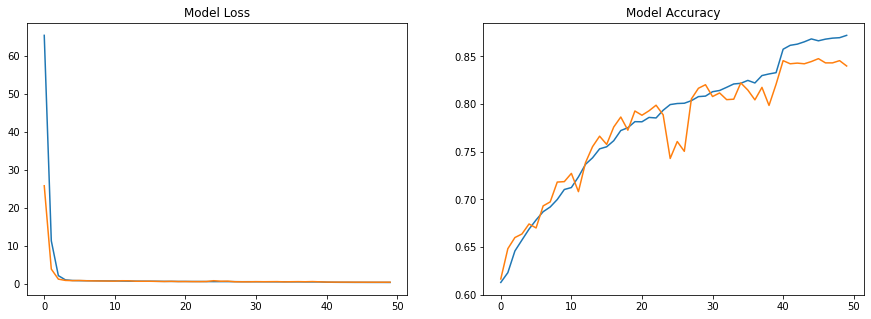

In [31]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

results = pd.DataFrame(history.history)

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(results[['loss', 'val_loss']])
axs[0].set_title('Model Loss')

axs[1].plot(results[['accuracy', 'val_accuracy']])
axs[1].set_title('Model Accuracy')

plt.show()

In [32]:
test = pd.read_csv('./cassava-leaf-disease-classification/sample_submission.csv')

test_path = './cassava-leaf-disease-classification/test_images'
def test_image_path(image):
    return os.path.join(test_path,image)

test['image_id'] = test['image_id'].apply(test_image_path)

test['label'] = test['label'].astype('str')

In [33]:
test.head()

image_id label
0  ./cassava-leaf-disease-classification/test_ima...     4

In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(dataframe=test, directory=None, x_col='image_id', y_col='label',
                                              preprocessing_function=applications.vgg16.preprocess_input,
                                              class_mode='categorical', target_size=(image_size,image_size))

Found 1 validated image filenames belonging to 1 classes.


In [35]:
output = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

In [ ]:
print(np.argmax(output))